In [9]:
import pandas as pd
import glob
import os
import torch
import numpy as np
from collections import defaultdict
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.utils import shuffle
import sdv
from sdv.single_table import CTGANSynthesizer
from sdv.metadata import SingleTableMetadata
import plotly.subplots as sp
import plotly.graph_objects as go
from sdv.evaluation.single_table import evaluate_quality, get_column_plot
from IPython.display import IFrame, display

In [10]:
data = pd.read_csv("data/train_X.csv")
data = data.sample(frac=0.1223, random_state=22)

In [11]:
display(dir(sdv.single_table))

['CTGANSynthesizer',
 'CopulaGANSynthesizer',
 'GaussianCopulaSynthesizer',
 'TVAESynthesizer',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 'base',
 'copulagan',
 'copulas',
 'ctgan',
 'utils']

In [12]:
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(data)
python_dict = metadata.to_dict()

In [13]:
metadata.validate_data(data=data)
import torch
print(torch.cuda.is_available()) 
print(torch.cuda.get_device_name(0)) 


True
NVIDIA GeForce RTX 4090


In [14]:
synthesizer = CTGANSynthesizer(
    metadata,
    enforce_rounding=False,
    epochs=100,
    batch_size=500,
    pac=5,
    verbose=True
)
synthesizer.fit(data)

ratios = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]  
results = {}

c:\Users\NAKULR\Documents\GitHub\IoT23-Anomaly-Detection\venv\Lib\site-packages\sdv\single_table\base.py:163: FutureWarning:

The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.

c:\Users\NAKULR\Documents\GitHub\IoT23-Anomaly-Detection\venv\Lib\site-packages\sdv\single_table\base.py:129: UserWarning:

We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.

Gen. (-0.21) | Discrim. (-0.20): 100%|██████████| 100/100 [27:22<00:00, 16.43s/it]


In [15]:
for ratio in ratios:
    num_rows = int(len(data) * ratio)
    print(f"\n--- Generating synthetic data of size {num_rows} ({ratio*100:.0f}% of subset) ---")
    
    synthetic_data = synthesizer.sample(num_rows=num_rows)
    quality_report = evaluate_quality(
        real_data=data,
        synthetic_data=synthetic_data,
        metadata=metadata
    )
    
    print(quality_report.get_score())  
    results[ratio] = quality_report.get_properties()


--- Generating synthetic data of size 60012 (25% of subset) ---
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 18/18 [00:00<00:00, 22.44it/s]|
Column Shapes Score: 75.85%

(2/2) Evaluating Column Pair Trends: |██████████| 153/153 [00:02<00:00, 60.29it/s]|
Column Pair Trends Score: 71.47%

Overall Score (Average): 73.66%

0.7365880492618002

--- Generating synthetic data of size 120024 (50% of subset) ---
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 18/18 [00:00<00:00, 18.59it/s]|
Column Shapes Score: 75.69%

(2/2) Evaluating Column Pair Trends: |██████████| 153/153 [00:02<00:00, 53.52it/s]|
Column Pair Trends Score: 71.42%

Overall Score (Average): 73.56%

0.735565311727768

--- Generating synthetic data of size 180036 (75% of subset) ---
Generating report ...

(1/2) Evaluating Column Shapes: |██████████| 18/18 [00:01<00:00, 15.14it/s]|
Column Shapes Score: 75.77%

(2/2) Evaluating Column Pair Trends: |██████████| 153/153 [00:03<00:00, 44.89

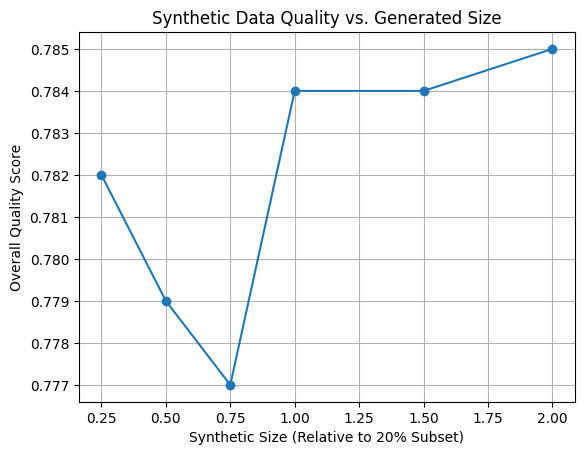

In [16]:
import matplotlib.pyplot as plt

sizes = [0.25, 0.5, 0.75, 1.0, 1.5, 2.0]
scores = [0.782, 0.779, 0.777, 0.784, 0.784, 0.785]

plt.plot(sizes, scores, marker='o')
plt.xlabel("Synthetic Size (Relative to 20% Subset)")
plt.ylabel("Overall Quality Score")
plt.title("Synthetic Data Quality vs. Generated Size")
plt.grid(True)
plt.show()
